# Data Preparation

In this notebook the goal is to prepare the dataset (csv or excel) to train the Random Forest Classifier for land cover classification. The dataset would be composed of : 

- annual fractional cover (bs, pv, npv)
- RGB
- NDVI, NDWI, NDWI, EVI
- DEM (elevation)
- seasonal fractional cover

In [1]:
import pandas as pd
import numpy as np 
import xarray as xr
import random
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import rasterio
from matplotlib.patches import Patch
import seaborn as sns

import os
import sys

from pystac_client import Client
import depal_ck as dep
from odc.stac import load
from shapely import geometry
import rioxarray
from dea_tools.dask import create_local_dask_cluster, create_dask_gateway_cluster

#client = create_local_dask_cluster(return_client=True)
from dask.distributed import Client as DaskClient

dask_client = DaskClient(n_workers=2,
            threads_per_worker=16,
            memory_limit='30GB',)

2025-08-29 03:19:22,815 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 96ab77a2c8e78cec5ffe15cd53823f38 initialized by task ('rechunk-merge-rechunk-transfer-ba0f84eddcaed6db7697e1bd4323f662', 0, 2, 2, 1, 3, 2) executed on worker tcp://127.0.0.1:42067
2025-08-29 03:19:22,942 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle da0e41274b1257ac0863b44fd54d0f27 initialized by task ('rechunk-merge-rechunk-transfer-ba0f84eddcaed6db7697e1bd4323f662', 0, 1, 0, 1, 2, 0) executed on worker tcp://127.0.0.1:42067
2025-08-29 03:19:22,998 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3ea81c1c855d15a5f8bdae4e5b0a2cd9 initialized by task ('rechunk-merge-rechunk-transfer-ba0f84eddcaed6db7697e1bd4323f662', 0, 2, 0, 1, 3, 0) executed on worker tcp://127.0.0.1:42067
2025-08-29 03:19:23,197 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 6dc2b9e6770561876ff9667c3408c660 initialized by task ('rechunk-merge-rechunk-transfer-ba0f84eddcaed6db7697e1bd4323f662', 0, 

In [2]:
catalog = "https://stac.staging.digitalearthpacific.io"
clients = Client.open(catalog)
collections = clients.get_collections()

In [3]:
# AOI FIJI CENTRAL + WESTERN
divisions = ['Central', 'Western']

# Fetch boundaries
gdfs = [dep.get_country_admin_boundary('Fiji', 'Division', division) for division in divisions]

# Union into one AOI
aoi = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)
aoi_union = aoi.unary_union

# Bounding box of the union
bbox = aoi_union.bounds 
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')
gdf.explore()

In [176]:
# AOI COOK ISLANDS
aoi = dep.get_country_admin_boundary('Cook Islands', 'Island Council', "Rarotonga")
bbox = dep.get_bbox(aoi)
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')

In [8]:
# AOI MARSHALL ISLANDS
aoi = dep.get_country_admin_boundary('Marshall Islands', 'Atoll', "Majuro")
bbox = dep.get_bbox(aoi)
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')


In [ ]:
# AOI PALAU 

# List of Palau states

states = [
    "Aimeliik",
    "Airai",
    "Melekeok",
    "Ngaraard",
    "Ngardmau",
    "Ngatpang",
    "Ngchesar",
    "Ngeremlengui",
    "Ngiwal", 
    "Ngarchelong",
    "Koror"
]


gdfs = [dep.get_country_admin_boundary('Palau', 'State', state) for state in states]

aoi = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)
aoi_union = aoi.unary_union

# Bounding box of the union
bbox = aoi_union.bounds 
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')
gdf.explore()

In [18]:
# for fiji test state 
states = ['Cakaudrove', 'Macuata']


gdfs = [dep.get_country_admin_boundary('Fiji', 'Province', state) for state in states]
# Concatenate into a single GeoDataFrame
aoi = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)


bbox = dep.get_bbox(aoi)
bbox = list(bbox)

# uncomment for fiji test
bbox[0] = 178.70143044283932 
bbox[2] = 179.95873926040082

bbox_geometry = geometry.box(*bbox)


gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')
gdf.explore()

In [42]:
# AOI MARSHALL ISLANDS
aoi = dep.get_country_admin_boundary('New Caledonia', 'Commune', "Nouméa")
bbox = dep.get_bbox(aoi)
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')


## ANNUAL FRACTIONAL COVER

In [43]:
items = clients.search(collections=["dep_ls_fc_summary_annual"], bbox=bbox).item_collection()
print(f"Found {len(items)} items")

Found 1 items


In [46]:
items = clients.search(
    collections=["dep_ls_fc_summary_annual"],
    bbox=bbox,
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data = load(items, chunks=chunks)


data = dep.do_coastal_clip(aoi, data, buffer=0.001)
fc = data[["bs_pc_50", "pv_pc_50", "npv_pc_50"]]


if not fc.rio.crs:
    print('change')
    fc = fc.rio.write_crs("EPSG:32658") 
    # COOK EPSG : 32604 / MARSHALL EPSG :32659 / FIJI EPSG : 32660 / PALAOS EPSG : 32653

# Reproject to EPSG:4326
fc= fc.rio.reproject("EPSG:4326") 
fc = fc.where(fc != 255, np.nan)


print(fc)

<xarray.Dataset> Size: 5MB
Dimensions:      (time: 1, y: 486, x: 817)
Coordinates:
  * x            (x) float64 7kB 166.3 166.3 166.3 166.3 ... 166.5 166.5 166.5
  * y            (y) float64 4kB -22.21 -22.21 -22.21 ... -22.34 -22.34 -22.34
  * time         (time) datetime64[ns] 8B 2024-01-01
    spatial_ref  int64 8B 0
Data variables:
    bs_pc_50     (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    pv_pc_50     (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    npv_pc_50    (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan


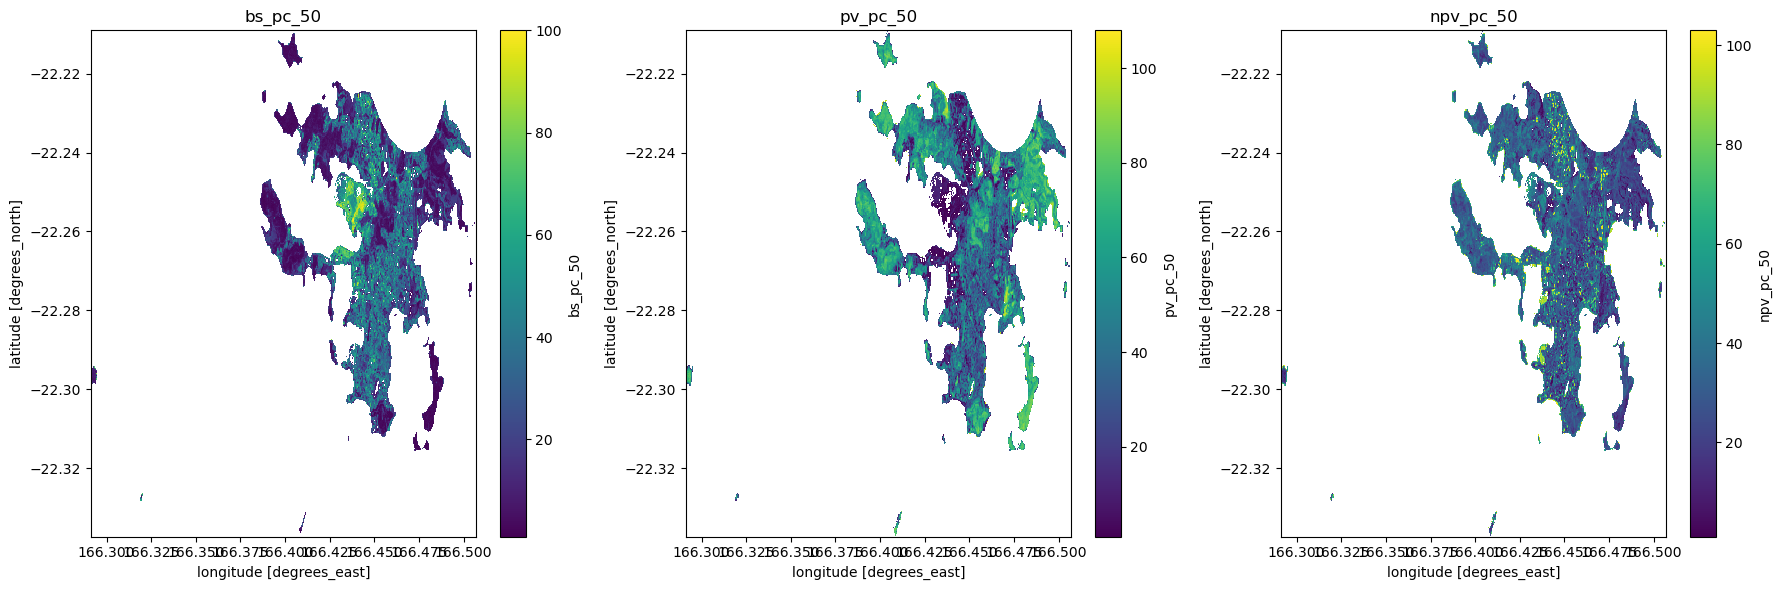

In [47]:
bands = ["bs_pc_50", "pv_pc_50", "npv_pc_50"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, band in enumerate(bands):
    fc[band].isel(time=0).plot(ax=axes[i], cmap="viridis")
    axes[i].set_title(band)

plt.tight_layout()
plt.show()

## RGB + INDEXES (NDVI, NDWI, NDBI, ...)

In [48]:
items = clients.search(collections=["dep_s2_geomad"], bbox=bbox).item_collection()
print(f"Found {len(items)} items")

Found 3 items


In [49]:
items = clients.search(
    collections=["dep_s2_geomad"],
    bbox=bbox,
    datetime="2024-01-01/2024-12-31",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data = load(items, chunks=chunks, like = fc.odc.geobox)
spectral = data[["red", "blue", "green", "nir08", "swir16", "emad", "smad", "bcmad"]]
spectral = dep.do_coastal_clip(aoi, spectral , buffer=0.001)
spectral = spectral.where(spectral != 0, np.nan)


print(spectral)

<xarray.Dataset> Size: 21MB
Dimensions:      (time: 1, latitude: 486, longitude: 817)
Coordinates:
  * latitude     (latitude) float64 4kB -22.21 -22.21 -22.21 ... -22.34 -22.34
  * longitude    (longitude) float64 7kB 166.3 166.3 166.3 ... 166.5 166.5 166.5
  * time         (time) datetime64[ns] 8B 2024-01-01
    spatial_ref  int64 8B 0
Data variables:
    red          (time, latitude, longitude) float64 3MB dask.array<chunksize=(1, 486, 817), meta=np.ndarray>
    blue         (time, latitude, longitude) float64 3MB dask.array<chunksize=(1, 486, 817), meta=np.ndarray>
    green        (time, latitude, longitude) float64 3MB dask.array<chunksize=(1, 486, 817), meta=np.ndarray>
    nir08        (time, latitude, longitude) float64 3MB dask.array<chunksize=(1, 486, 817), meta=np.ndarray>
    swir16       (time, latitude, longitude) float64 3MB dask.array<chunksize=(1, 486, 817), meta=np.ndarray>
    emad         (time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 486, 817), m

In [50]:


def add_indices(data: xr.Dataset) -> xr.Dataset:
    """
    Add common spectral indices to a Sentinel-2 xarray Dataset.
    Works with bands: red, green, blue, nir08, swir16.
    """
    # Ensure float32 for calculations
    for band in ["red", "green", "blue", "nir08", "swir16"]:
        data[band] = data[band].astype("float64")

    # NDVI = (NIR - Red) / (NIR + Red)
    data["ndvi"] = (data["nir08"] - data["red"]) / (data["nir08"] + data["red"])

    # MNDWI = (Green - SWIR) / (Green + SWIR)
    data["mndwi"] = (data["green"] - data["swir16"]) / (data["green"] + data["swir16"])

    # EVI = 2.5 * (NIR - Red) / (NIR + 6*Red - 7.5*Blue + 1)
    data["evi"] = (2.5 * (data["nir08"] - data["red"])) / (data["nir08"] + 6 * data["red"] - 7.5 * data["blue"] + 1)

    # SAVI = (1 + L) * (NIR - Red) / (NIR + Red + L), L=0.5
    L = 0.5
    #data["savi"] = (1 + L) * (data["nir08"] - data["red"]) / (data["nir08"] + data["red"] + L)

    # BSI (Bare Soil Index) = (SWIR + Red - NIR - Blue) / (SWIR + Red + NIR + Blue)
    #data["bsi"] = (data["swir16"] + data["red"] - data["nir08"] - data["blue"]) / (
    #    data["swir16"] + data["red"] + data["nir08"] + data["blue"]
    #)

    # NDMI (Normalized Difference Moisture Index) = (NIR - SWIR) / (NIR + SWIR)
    #data["ndmi"] = (data["nir08"] - data["swir16"]) / (data["nir08"] + data["swir16"])

    # NDBI (Normalized Difference Built-up Index) = (SWIR - NIR) / (SWIR + NIR)
    data["ndbi"] = (data["swir16"] - data["nir08"]) / (data["swir16"] + data["nir08"])

    return data


In [51]:
spectral = add_indices(spectral)

if not spectral.rio.crs:
    spectral = spectral.rio.write_crs("EPSG:3832")  

spectral = spectral.rio.reproject("EPSG:4326")
spectral = spectral.rio.reproject_match(fc)

#spectral = spectral.drop_vars(["spatial_ref"])
print(spectral)

<xarray.Dataset> Size: 33MB
Dimensions:      (time: 1, x: 817, y: 486)
Coordinates:
  * time         (time) datetime64[ns] 8B 2024-01-01
    spatial_ref  int64 8B 0
  * x            (x) float64 7kB 166.3 166.3 166.3 166.3 ... 166.5 166.5 166.5
  * y            (y) float64 4kB -22.21 -22.21 -22.21 ... -22.34 -22.34 -22.34
Data variables:
    red          (time, y, x) float64 3MB nan nan nan nan ... nan nan nan nan
    blue         (time, y, x) float64 3MB nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float64 3MB nan nan nan nan ... nan nan nan nan
    nir08        (time, y, x) float64 3MB nan nan nan nan ... nan nan nan nan
    swir16       (time, y, x) float64 3MB nan nan nan nan ... nan nan nan nan
    emad         (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    smad         (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    bcmad        (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    ndvi         (time, y, x) float64

In [52]:
spectral.ndvi.isel(time=0).odc.explore()

## SEASONNAL FRACTIONAL COVER 

In [58]:
####################################################################
# LOAD DATA 
####################################################################

# WOFL Landsat-8 Image --> USED AS THE MASK TO REMOVE CLOUD
items = clients.search(collections=["dep_ls_wofl"], bbox=bbox, datetime="2024-01-01/2024-12-31").item_collection()

items = clients.search(
    collections=["dep_ls_wofl"],
    bbox=bbox,
    datetime="2024-01-01/2024-12-31",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data_temoin = load(items, chunks=chunks, groupby = 'solar_day', like = fc.odc.geobox) 
data_temoin = dep.do_coastal_clip(aoi, data_temoin , buffer=0.001)

# FC Landsat-8 Image 
items = clients.search(
    collections=["dep_ls_fc"],
    bbox=bbox,
    datetime="2024-01-01/2024-12-31",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data = load(items, chunks=chunks,  groupby = 'solar_day', like = fc.odc.geobox)
data = dep.do_coastal_clip(aoi, data, buffer=0.001)

#######################################################################
# MERGE DATA AND MASK CLOUDS
#######################################################################
merged = data.merge(data_temoin) # remain on dask youpiiiii
masked = merged.where(merged['water'] != 1, np.nan)
clean = masked.where(masked != 255)

#########################################################################
# GROUP BY SEASON
#########################################################################

seasons = []
for t in clean['time'].dt.month.values:
    if t in [1, 2, 3, 4]:
        seasons.append("jan_apr")
    elif t in [5, 6, 7, 8]:
        seasons.append("may_aug")
    else:
        seasons.append("sep_dec")


clean = clean.assign_coords(season=("time", seasons))
clean = clean.drop_vars("water")
clean = clean.drop_vars("ue")


fc_seasonal = clean.groupby("season").median(dim="time")

if not fc_seasonal.rio.crs:
    fc_seasonal = fc_seasonal.rio.write_crs("EPSG:32653")
    # COOK EPSG : 32604 / MARSHALL EPSG :32659 / FIJI EPSG : 32660 / PALAOS EPSG : 32653
fc_seasonal = fc_seasonal.rio.reproject("EPSG:4326")
fc_seasonal = fc_seasonal.rio.reproject_match(fc)



fc_jan_apr = fc_seasonal.sel(season="jan_apr")
fc_may_aug = fc_seasonal.sel(season="may_aug")
fc_sep_dec = fc_seasonal.sel(season="sep_dec")


print(fc_jan_apr)

<xarray.Dataset> Size: 5MB
Dimensions:      (x: 817, y: 486)
Coordinates:
    season       <U7 28B 'jan_apr'
    spatial_ref  int64 8B 0
  * x            (x) float64 7kB 166.3 166.3 166.3 166.3 ... 166.5 166.5 166.5
  * y            (y) float64 4kB -22.21 -22.21 -22.21 ... -22.34 -22.34 -22.34
Data variables:
    bs           (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan nan
    pv           (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan nan
    npv          (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan nan


In [ ]:
jan_apr = {
        "bs": "bs_jan_apr",
        "pv": "pv_jan_apr",
        "npv": "npv_jan_apr"
    }

fc_jan_apr = fc_jan_apr.rename(jan_apr)
#fc_jan_apr = fc_jan_apr.drop_vars(["spatial_ref", "season"])
time_coord = pd.to_datetime("2024-01-01")
fc_jan_apr = fc_jan_apr.expand_dims(time=[time_coord])
fc_jan_apr = fc_jan_apr.transpose('time', 'y', 'x')

may_aug = {
        "bs": "bs_may_aug",
        "pv": "pv_may_aug",
        "npv": "npv_may_aug"
    }

fc_may_aug = fc_may_aug.rename_vars(may_aug)
fc_may_aug = fc_may_aug.drop_vars(["spatial_ref", "season"])
fc_may_aug = fc_may_aug.expand_dims(time=[time_coord])
fc_may_aug = fc_may_aug.transpose('time', 'y', 'x')


sep_dec = {
        "bs": "bs_sep_dec",
        "pv": "pv_sep_dec",
        "npv": "npv_sep_dec"
    }

fc_sep_dec = fc_sep_dec.rename_vars(sep_dec)
fc_sep_dec = fc_sep_dec.drop_vars(["spatial_ref", "season"])
fc_sep_dec = fc_sep_dec.expand_dims(time=[time_coord])
fc_sep_dec = fc_sep_dec.transpose('time', 'y', 'x')

fc_jan_apr

## DEM 

In [62]:
# run_task.py
from dep_tools.searchers import PystacSearcher

def get_dem_searcher():
    """Return a PystacSearcher for DEM (Copernicus DEM)."""
    return PystacSearcher(
        catalog="https://earth-search.aws.element84.com/v1",
        collections=["cop-dem-glo-30"],
    )

In [63]:
dem_searcher = get_dem_searcher()

# Run searches
gdf = fc.odc.geobox
dem_items = dem_searcher.search(gdf)

print("DEM items:", len(dem_items))

DEM items: 1


In [64]:
from dep_tools.loaders import OdcLoader
loader = OdcLoader(
    chunks=dict( x=2048, y=2048),
)


dem_data = loader.load(dem_items, gdf)
dem_data = dep.do_coastal_clip(aoi, dem_data, buffer=0.001)

dem_data = dem_data.rename({
    "latitude": "y",
    "longitude": "x"
})
dem_data = dem_data.assign_coords(time=[np.datetime64("2024-01-01")])
dem_data = dem_data.rename({"data": "dem"})
dem_data = dem_data.drop_vars("spatial_ref")
dem_data = dem_data.rio.write_crs("EPSG:4326")
dem_data = dem_data.rio.reproject_match(fc)


print(dem_data)

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 1, x: 817, y: 486)
Coordinates:
  * time         (time) datetime64[s] 8B 2024-01-01
    spatial_ref  int64 8B 0
  * x            (x) float64 7kB 166.3 166.3 166.3 166.3 ... 166.5 166.5 166.5
  * y            (y) float64 4kB -22.21 -22.21 -22.21 ... -22.34 -22.34 -22.34
Data variables:
    dem          (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan


In [65]:
dem_data.dem.isel(time=0).odc.explore()

## Create dataset (data + label) for training

In [66]:
dem_data['x'] = fc['x']
dem_data['y'] = fc['y']

spectral['x'] = fc['x']
spectral['y'] = fc['y']

fc_jan_apr['x'] = fc['x']
fc_jan_apr['y'] = fc['y']

fc_may_aug['x'] = fc['x']
fc_may_aug['y'] = fc['y']

fc_sep_dec['x'] = fc['x']
fc_sep_dec['y'] = fc['y']

datasets = xr.merge([fc, spectral, fc_jan_apr, fc_may_aug, fc_sep_dec, dem_data], join='left')
datasets

<xarray.Dataset> Size: 54MB
Dimensions:      (x: 817, y: 486, time: 1)
Coordinates:
  * x            (x) float64 7kB 166.3 166.3 166.3 166.3 ... 166.5 166.5 166.5
  * y            (y) float64 4kB -22.21 -22.21 -22.21 ... -22.34 -22.34 -22.34
  * time         (time) datetime64[ns] 8B 2024-01-01
    spatial_ref  int64 8B 0
Data variables: (12/25)
    bs_pc_50     (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    pv_pc_50     (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    npv_pc_50    (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    red          (time, y, x) float64 3MB nan nan nan nan ... nan nan nan nan
    blue         (time, y, x) float64 3MB nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float64 3MB nan nan nan nan ... nan nan nan nan
    ...           ...
    pv_may_aug   (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    npv_may_aug  (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    bs_sep_dec   (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    pv_sep_dec   (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    npv_sep_dec  (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan
    dem          (time, y, x) float32 2MB nan nan nan nan ... nan nan nan nan

In [67]:
datasets.bs_jan_apr.isel(time=0).odc.explore()

In [62]:
# Interpolate on points 

gdf = gpd.read_file("./data/label/lulc_fiji_test.gpkg")

# Get coords
coords_x = gdf.geometry.x.values
coords_y = gdf.geometry.y.values
n_points = len(gdf)


sampled = datasets.interp(
    x=("points", coords_x),
    y=("points", coords_y),
    method="nearest"
)

sampled

<xarray.Dataset> Size: 365kB
Dimensions:      (time: 1, points: 2401)
Coordinates:
  * time         (time) datetime64[ns] 8B 2024-01-01
    spatial_ref  int64 8B 0
    x            (points) float64 19kB 179.9 179.7 179.9 ... 179.6 179.6 179.4
    y            (points) float64 19kB -16.19 -16.2 -16.2 ... -16.26 -16.36
Dimensions without coordinates: points
Data variables: (12/25)
    bs_pc_50     (time, points) float32 10kB 5.0 3.0 3.0 3.0 ... 3.0 6.0 7.0 6.0
    pv_pc_50     (time, points) float32 10kB 67.0 92.0 69.0 ... 93.0 99.0 99.0
    npv_pc_50    (time, points) float32 10kB 25.0 10.0 24.0 8.0 ... 6.0 3.0 4.0
    red          (time, points) float64 19kB 590.0 500.0 823.0 ... 152.0 210.0
    blue         (time, points) float64 19kB 421.0 453.0 527.0 ... 173.0 257.0
    green        (time, points) float64 19kB 655.0 786.0 782.0 ... 355.0 512.0
    ...           ...
    pv_may_aug   (time, points) float32 10kB nan nan nan nan ... 43.5 nan nan
    npv_may_aug  (time, points) float32 10kB nan nan nan nan ... 53.0 nan nan
    bs_sep_dec   (time, points) float32 10kB nan nan nan nan ... 12.0 nan nan
    pv_sep_dec   (time, points) float32 10kB nan nan nan nan ... 49.0 nan nan
    npv_sep_dec  (time, points) float32 10kB nan nan nan nan ... 64.0 nan nan
    dem          (time, points) float32 10kB 12.98 6.858 25.92 ... 3.867 3.671

In [63]:
df = sampled.to_dataframe().reset_index()

df["class_id"] = gdf["class_id"].values 
df["lulc"] = gdf["lulc"].values
df = df.drop(["time", "points", "spatial_ref"], axis=1)
df = df.dropna(axis = 0) 
print(f'Number of points : {len(df)}')
df.head()

Number of points : 1257


,bs_pc_50,pv_pc_50,npv_pc_50,red,blue,green,nir08,swir16,emad,smad,...,pv_may_aug,npv_may_aug,bs_sep_dec,pv_sep_dec,npv_sep_dec,dem,x,y,class_id,lulc
11,6.0,98.0,7.0,263.0,268.0,498.0,3732.0,1111.0,437.945221,0.000638,...,86.0,23.0,15.5,60.5,60.5,5.639843,179.780273,-16.215161,2,cropland
21,6.0,92.0,4.0,284.0,311.0,477.0,3979.0,1300.0,1008.638489,0.001419,...,79.0,65.0,7.0,67.5,28.0,28.763420,179.780445,-16.227350,1,forest
33,6.0,90.0,3.0,267.0,317.0,573.0,4403.0,1549.0,896.542480,0.000988,...,49.0,61.0,15.5,69.5,57.0,50.373661,179.742761,-16.240034,1,forest
36,12.0,84.0,14.0,286.0,288.0,426.0,3048.0,1328.0,840.690308,0.000840,...,53.5,26.0,19.0,71.0,16.0,19.020502,179.755380,-16.239870,1,forest
37,5.0,84.0,10.0,303.0,307.0,464.0,3339.0,1270.0,882.464111,0.000864,...,79.5,12.0,22.5,64.5,14.0,32.933216,179.767998,-16.239705,1,forest


In [64]:
gdf_out = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["x"], df["y"]),
    crs="EPSG:4326"   
)

gdf_out = gdf_out.drop(columns=["x", "y"])

# Save as GeoPackage and CSV
out_path = "./data/preparation/fiji_test_dataset.gpkg"
gdf_out.to_file(out_path, driver="GPKG")
gdf_out.to_csv('./data/preparation/fiji_test_dataset.csv')

In [69]:
# SAVE FOR TESTING 

output_path = "./data/preparation/noumea.nc"
datasets.to_netcdf(output_path)

## FOR LATER MAYBE

## SENTINEL 1 (RADAR)

In [20]:
items = clients.search(collections=["dep_s1_geomad"], bbox=bbox).item_collection()
print(f"Found {len(items)} items")

Found 4 items


In [21]:
items = clients.search(
    collections=["dep_s1_geomad"],
    bbox=bbox,
).items()
chunks = dict(x=2048, y=2048)

# Load the data
radar = load(items, chunks=chunks)

radar = dep.do_coastal_clip(aoi, radar, buffer=0.001)

print(radar)

<xarray.Dataset> Size: 5GB
Dimensions:      (y: 12291, x: 11093, time: 1)
Coordinates:
  * y            (y) float64 98kB -1.952e+06 -1.952e+06 ... -2.075e+06
  * x            (x) float64 89kB 3.092e+06 3.092e+06 ... 3.203e+06 3.203e+06
  * time         (time) datetime64[ns] 8B 2024-01-01
    spatial_ref  int64 8B 0
Data variables:
    vh           (time, y, x) float32 545MB dask.array<chunksize=(1, 1787, 1783), meta=np.ndarray>
    vv           (time, y, x) float32 545MB dask.array<chunksize=(1, 1787, 1783), meta=np.ndarray>
    emad         (time, y, x) float32 545MB dask.array<chunksize=(1, 1787, 1783), meta=np.ndarray>
    smad         (time, y, x) float32 545MB dask.array<chunksize=(1, 1787, 1783), meta=np.ndarray>
    bcmad        (time, y, x) float32 545MB dask.array<chunksize=(1, 1787, 1783), meta=np.ndarray>
    count        (time, y, x) uint16 273MB dask.array<chunksize=(1, 1787, 1783), meta=np.ndarray>
    mean_vh      (time, y, x) float32 545MB dask.array<chunksize=(1, 1787,

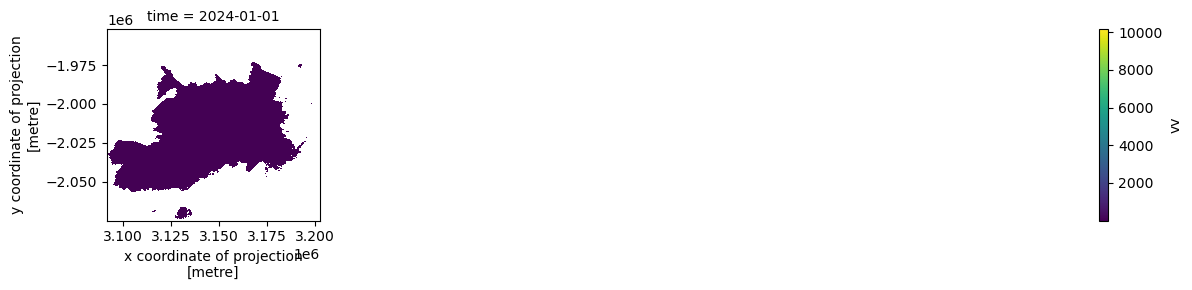

In [18]:
dep.visualise(radar['vv'])

In [ ]:
# IF 0 ITEMS FOUND ON DEP STAC API STAGING 
from dep_tools.searchers import PystacSearcher
from datetime import date

def get_sentinel_searcher():
    today = date.today().isoformat()
    return PystacSearcher(
        catalog = "https://planetarycomputer.microsoft.com/api/stac/v1",
        collections=["sentinel-1-rtc"],  
        datetime="2020-01-01/2024-12-31",
    )


s2_searcher = get_sentinel_searcher()
items = s2_searcher.search(gdf)  
print(len(items), "items found")

## GLCM TEXTURE 

In [ ]:
import dask.array as da
from skimage.feature import graycomatrix, graycoprops

def glcm_features(patch, distances=[1, 2], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=32):
    # Skip NaNs / uniform patches
    if np.isnan(patch).any() or patch.max() == patch.min():
        return {k: np.nan for k in [
            "contrast","dissimilarity","homogeneity",
            "energy","correlation","entropy","ASM"
        ]}

    # Scale NDVI-like values [-1,1] → [0,levels-1]
    patch_scaled = np.clip(((patch + 1) * (levels-1)/2).astype(np.uint8), 0, levels-1)

    glcm = graycomatrix(
        patch_scaled,
        distances=distances,
        angles=angles,
        levels=levels,
        symmetric=True,
        normed=True,
    )

    # Average over angles and distances
    contrast = graycoprops(glcm, 'contrast').mean()
    dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy = graycoprops(glcm, 'energy').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    asm = graycoprops(glcm, 'ASM').mean()

    # Entropy
    p = glcm / glcm.sum()
    p = p[p > 0]
    entropy = -np.sum(p * np.log2(p))

    return {
        "contrast": contrast,
        "dissimilarity": dissimilarity,
        "homogeneity": homogeneity,
        "energy": energy,
        "correlation": correlation,
        "entropy": entropy,
        "ASM": asm,
    }

def compute_glcm_patchwise(band_da, window_size=31, levels=32):
    """
    band_da: xarray.DataArray with dims (y, x)
    window_size: odd integer (e.g., 15, 31, 41)
    """
    ysize, xsize = band_da.shape[-2:]
    pad_y = int((window_size - ysize % window_size) % window_size)
    pad_x = int((window_size - xsize % window_size) % window_size)

    # Pad correctly: ((top,bottom), (left,right))
    padded = da.pad(band_da.data, ((0, pad_y), (0, pad_x)), mode="reflect")

    # Split into patches
    reshaped = padded.reshape(
        padded.shape[0] // window_size, window_size,
        padded.shape[1] // window_size, window_size
    )
    patches = reshaped.swapaxes(1, 2) 

    # Compute GLCM for each patch
    n_py, n_px, _, _ = patches.shape
    features = {k: np.full((n_py, n_px), np.nan, dtype=np.float32)
                for k in ["contrast","dissimilarity","homogeneity",
                          "energy","correlation","entropy","ASM"]}

    for i in range(n_py):
        for j in range(n_px):
            patch = patches[i, j].compute()
            feats = glcm_features(patch, levels=levels)
            for k, v in feats.items():
                features[k][i, j] = v

    # Expand back to full resolution
    def upscale(arr):
        return np.repeat(np.repeat(arr, window_size, axis=0), window_size, axis=1)[:ysize, :xsize]

    ds = xr.Dataset(
        {k: (("y", "x"), upscale(v)) for k, v in features.items()},
        coords={"y": band_da.y, "x": band_da.x}
    )

    return ds


######################################################################
# Example usage
# Assume spectral["ndvi"] is (y,x)
ndvi = spectral["ndvi"]
ndvi = spectral["ndvi"].squeeze("time", drop=True)

# Try two scales (multi-scale texture)
glcm = compute_glcm_patchwise(ndvi, window_size=31, levels=32)

# Add time dimension
time_coord = pd.to_datetime("2024-01-01")
glcm = glcm.expand_dims(time=[time_coord])


print(glcm)


In [ ]:
dep.visualise(glcm['ASM'])